In [1]:
import pandas as pd
from abc import ABC, abstractmethod
import nbimporter
import numpy as np
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator, StochasticOscillator, WilliamsRIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from ta.momentum import ROCIndicator
from dataloader import get_cryptoquant_data

pd.set_option('display.max_rows', None)

In [2]:
class ISignalGeneration(ABC):
    @abstractmethod
    def strategic(self, cryptoquant_data):
        pass

In [3]:
class SignalRegen(ISignalGeneration):
    def strategic(self, data):
        # RSI (14-period)
        rsi = RSIIndicator(close=data['close'], window=14)
        data['rsi'] = rsi.rsi()

        # Stochastic Oscillator (14,3,3)
        stoch = StochasticOscillator(high=data['high'], low=data['low'], close=data['close'], window=14, smooth_window=3)
        data['stoch_k'] = stoch.stoch()
        data['stoch_d'] = stoch.stoch_signal()

        # MACD (12,26,9)
        macd = MACD(close=data['close'], window_slow=26, window_fast=12, window_sign=9)
        data['macd'] = macd.macd()
        data['macd_signal'] = macd.macd_signal()
        data['macd_hist'] = macd.macd_diff()

        # Bollinger Bands (20,2)
        bb = BollingerBands(close=data['close'], window=20, window_dev=2)
        data['bb_upper'] = bb.bollinger_hband()
        data['bb_lower'] = bb.bollinger_lband()
        data['bb_middle'] = bb.bollinger_mavg()

        # Momentum (10-period Rate of Change)
        momentum = ROCIndicator(close=data['close'], window=10)
        data['momentum'] = momentum.roc()

        return data 


In [4]:
def get_signal_generation():
    data = get_cryptoquant_data(filtered=False)
    data = SignalRegen().strategic(data)

    return data

In [5]:
data = get_signal_generation()
print(data.head())

                        close      high       low      open        volume  \
datetime                                                                    
2019-04-14 16:00:00  0.323948  0.326291  0.323533  0.324713  1.842778e+06   
2019-04-14 17:00:00  0.324483  0.326076  0.323908  0.324537  1.364595e+06   
2019-04-14 18:00:00  0.325284  0.327979  0.324100  0.324426  1.041596e+06   
2019-04-14 19:00:00  0.324380  0.326305  0.324001  0.325160  1.604163e+06   
2019-04-14 20:00:00  0.324159  0.326285  0.323473  0.324317  2.378098e+06   

                     rsi  stoch_k  stoch_d  macd  macd_signal  macd_hist  \
datetime                                                                   
2019-04-14 16:00:00  NaN      NaN      NaN   NaN          NaN        NaN   
2019-04-14 17:00:00  NaN      NaN      NaN   NaN          NaN        NaN   
2019-04-14 18:00:00  NaN      NaN      NaN   NaN          NaN        NaN   
2019-04-14 19:00:00  NaN      NaN      NaN   NaN          NaN        NaN   
2019

In [6]:
data = get_signal_generation()

print(data.head(10))

data['rsi_signal'] = 0
data.loc[data['rsi'] < 30, 'rsi_signal'] = 1  # Buy if RSI < 30 (oversold)
data.loc[data['rsi'] > 70, 'rsi_signal'] = -1  # Sell if RSI > 70 (overbought)

data['stoch_signal'] = 0
data.loc[(data['stoch_k'] > data['stoch_d']) & (data['stoch_k'] < 20), 'stoch_signal'] = 1  # Bullish crossover in oversold
data.loc[(data['stoch_k'] < data['stoch_d']) & (data['stoch_k'] > 80), 'stoch_signal'] = -1  # Bearish crossover in overbought

data['macd_signal'] = 0
data.loc[data['macd'] > data['macd_signal'], 'macd_signal'] = 1  # MACD line above signal line
data.loc[data['macd'] < data['macd_signal'], 'macd_signal'] = -1

data['bb_signal'] = 0
data.loc[data['close'] <= data['bb_lower'], 'bb_signal'] = 1  # Buy if price touches lower band
data.loc[data['close'] >= data['bb_upper'], 'bb_signal'] = -1  # Sell if price touches upper band

data['momentum_signal'] = 0
data.loc[data['momentum'] > 0, 'momentum_signal'] = 1  # Buy if momentum is positive
data.loc[data['momentum'] < 0, 'momentum_signal'] = -1


                        close      high       low      open        volume  \
datetime                                                                    
2019-04-14 16:00:00  0.323948  0.326291  0.323533  0.324713  1.842778e+06   
2019-04-14 17:00:00  0.324483  0.326076  0.323908  0.324537  1.364595e+06   
2019-04-14 18:00:00  0.325284  0.327979  0.324100  0.324426  1.041596e+06   
2019-04-14 19:00:00  0.324380  0.326305  0.324001  0.325160  1.604163e+06   
2019-04-14 20:00:00  0.324159  0.326285  0.323473  0.324317  2.378098e+06   
2019-04-14 21:00:00  0.325073  0.326871  0.323155  0.324550  1.639148e+06   
2019-04-14 22:00:00  0.327741  0.330165  0.325199  0.325151  6.047172e+06   
2019-04-14 23:00:00  0.328461  0.330713  0.326386  0.327366  4.755579e+06   
2019-04-15 00:00:00  0.328813  0.331135  0.327871  0.328222  4.174136e+06   
2019-04-15 01:00:00  0.329481  0.332032  0.328925  0.329156  5.511346e+06   

                     rsi  stoch_k  stoch_d  macd  macd_signal  macd_hist  \

In [7]:
# Buy condition: At least 2 indicators are +1 (Buy)
buy_condition = (
    (data["rsi_signal"] == 1).astype(int) +
    (data["stoch_signal"] == 1).astype(int) +
    (data["macd_signal"] == 1).astype(int) +
    (data["bb_signal"] == 1).astype(int) +
    (data["momentum_signal"] == 1).astype(int)
) >= 2

# Sell condition: At least 3 indicators are -1 (Sell)
sell_condition = (
    (data["rsi_signal"] == -1).astype(int) +
    (data["stoch_signal"] == -1).astype(int) +
    (data["macd_signal"] == -1).astype(int) +
    (data["bb_signal"] == -1).astype(int) +
    (data["momentum_signal"] == -1).astype(int)
) >= 3

# Assign final signals
data["final_signal"] = 0
data.loc[buy_condition, "final_signal"] = 1    
data.loc[sell_condition, "final_signal"] = -1  

trade_counts = data["final_signal"].value_counts()
print(f"Count of 1 (buy signal): {trade_counts.get(1, 0)}")
print(f"Count of -1 (sell signal): {trade_counts.get(-1, 0)}")
freq = ((data["final_signal"] == 1) | (data["final_signal"] == -1)).sum() / len(data)
print(f"frequency: {freq}")


Count of 1 (buy signal): 1672
Count of -1 (sell signal): 1816
frequency: 0.0663647779595875


In [8]:
print(data.head(10))

                        close      high       low      open        volume  \
datetime                                                                    
2019-04-14 16:00:00  0.323948  0.326291  0.323533  0.324713  1.842778e+06   
2019-04-14 17:00:00  0.324483  0.326076  0.323908  0.324537  1.364595e+06   
2019-04-14 18:00:00  0.325284  0.327979  0.324100  0.324426  1.041596e+06   
2019-04-14 19:00:00  0.324380  0.326305  0.324001  0.325160  1.604163e+06   
2019-04-14 20:00:00  0.324159  0.326285  0.323473  0.324317  2.378098e+06   
2019-04-14 21:00:00  0.325073  0.326871  0.323155  0.324550  1.639148e+06   
2019-04-14 22:00:00  0.327741  0.330165  0.325199  0.325151  6.047172e+06   
2019-04-14 23:00:00  0.328461  0.330713  0.326386  0.327366  4.755579e+06   
2019-04-15 00:00:00  0.328813  0.331135  0.327871  0.328222  4.174136e+06   
2019-04-15 01:00:00  0.329481  0.332032  0.328925  0.329156  5.511346e+06   

                     rsi  stoch_k  stoch_d  macd  macd_signal  macd_hist  \

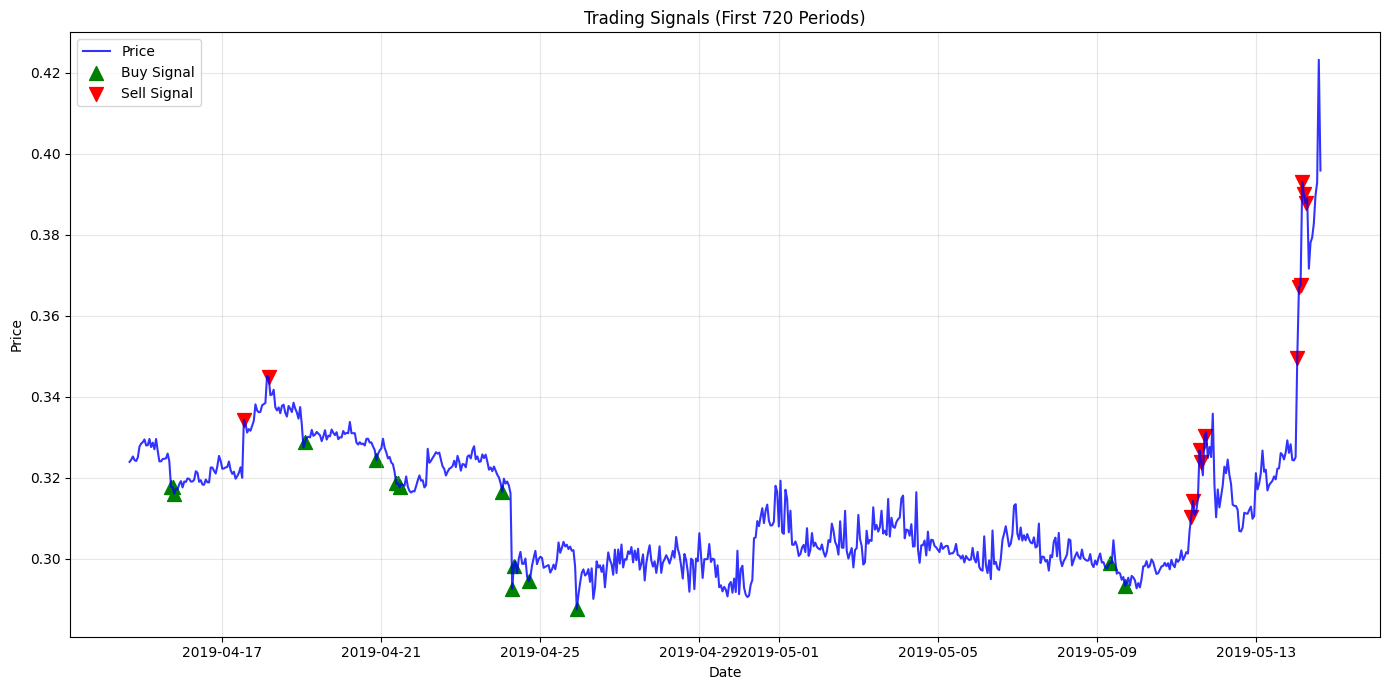

In [9]:
plt.figure(figsize=(14, 7))

# Plot price line (first 720 hours)
plot_data = data.iloc[:720]

plt.plot(plot_data.index, plot_data['close'], 
         label='Price', color='blue', alpha=0.8)

# Buy signals
plt.scatter(
    plot_data[plot_data['final_signal'] == 1].index,
    plot_data[plot_data['final_signal'] == 1]['close'],
    color='green',
    marker='^',
    s=100,
    label='Buy Signal'
)

# Sell signals
plt.scatter(
    plot_data[plot_data['final_signal'] == -1].index,
    plot_data[plot_data['final_signal'] == -1]['close'],
    color='red',
    marker='v',
    s=100,
    label='Sell Signal'
)

plt.title('Trading Signals (First 720 Periods)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout() 
plt.show()

In [10]:
# Calculate returns and account for transaction costs
returns = []
trade_count = 0
fee_rate = 0.0006  # 0.06%

position_storage = 0
entry_prices = []  # Store entry prices for each position
entry_times = []   # Store entry timestamps
hourly_returns = np.zeros(len(data))  # Array to store returns for each hour
cumulative_returns = np.zeros(len(data))  # Array to store cumulative returns

for i in range(len(data)):
    current_price = data['close'].iloc[i]
    signal = data['final_signal'].iloc[i]
    
    # Buy signal
    if signal == 1:
        position_storage += 1
        trade_count += 1
        entry_price = current_price * (1 + fee_rate)  # Add fee to entry price
        entry_prices.append(entry_price)
        entry_times.append(i)
    
    # Sell signal and we have positions
    elif signal == -1 and position_storage > 0:
        exit_price = current_price * (1 - fee_rate)  # Subtract fee from exit price
        
        # Process each position we're closing
        for entry_price, entry_time in zip(entry_prices, entry_times):
            # Calculate total log return for the position
            total_log_return = np.log(exit_price / entry_price)
            
            # Calculate holding period
            holding_period = i - entry_time
            if holding_period > 0:
                # Distribute the log return evenly across the holding period
                per_hour_return = total_log_return / holding_period
                hourly_returns[entry_time+1:i+1] += per_hour_return
        
        # Reset position tracking
        position_storage = 0
        entry_prices = []
        entry_times = []

# Calculate cumulative returns
cumulative_returns = np.exp(np.cumsum(hourly_returns)) - 1

# Calculate maximum drawdown
peaks = np.maximum.accumulate(cumulative_returns)
drawdowns = (cumulative_returns - peaks) / (1 + peaks)
max_drawdown = np.min(drawdowns)

# Calculate metrics
trade_frequency = trade_count / len(data)

# Calculate Sharpe Ratio (using 365 * 24 hours per year)
annual_factor = 365 * 24  # Hours in a year
risk_free_rate = 0.02  # Assuming 2% annual risk-free rate

# Use only non-zero returns for Sharpe calculation
active_returns = hourly_returns[hourly_returns != 0]
mean_hourly_return = np.mean(active_returns) if len(active_returns) > 0 else 0
std_hourly_return = np.std(active_returns) if len(active_returns) > 0 else 0
sharpe = np.sqrt(annual_factor) * (mean_hourly_return - risk_free_rate/annual_factor) / std_hourly_return if std_hourly_return > 0 else 0

print(f"Number of trades: {trade_count}")
print(f"Trading frequency (trades per hour): {trade_frequency:.4f}")
print(f"Sharpe ratio: {sharpe:.4f}")
print(f"Maximum drawdown: {max_drawdown:.4%}")

Number of trades: 1672
Trading frequency (trades per hour): 0.0318
Sharpe ratio: 3.0904
Maximum drawdown: -99.9985%
